**In this notebook all the algorithms will be fine-tuned and retrained by integrating the CodeCarbon library which produces sustainability reports.**

**https://github.com/mlco2/codecarbon.git**

In [1]:
!pip install nilearn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pip install codecarbon

**Random Forests**

In [6]:
# Import the necessary libraries
import nilearn
from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
from sklearn.impute import SimpleImputer


**Pre-Processing**

In [59]:
# Fetch the Oasis VBM dataset
oasis_data=nilearn.datasets.fetch_oasis_vbm(n_subjects=None, dartel_version=True)

[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

In [60]:
# Load the DataFrame with clinical and demographic variables
ext_vars = pd.DataFrame(oasis_data['ext_vars'])

In [61]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Set 'id' column as index
ext_vars = ext_vars.set_index('id')

# Drop 'hand' and 'delay' columns
# The 'hand' column is excluded because all subjects are right-handed, offering no variability or discriminatory power.
# The 'delay' column is removed as it consists entirely of Nans, providing no information for the analysis.
ext_vars = ext_vars.drop(columns=['hand', 'delay'], errors='ignore')

# Set all NaN values in 'cdr' to 0.0
ext_vars['cdr'] = ext_vars['cdr'].fillna(0.0)

# Impute 'mmse', 'ses', and 'educ' with their median values
median_imputer = SimpleImputer(strategy='median')
for col in ['mmse', 'ses', 'educ']:
    ext_vars[[col]] = median_imputer.fit_transform(ext_vars[[col]])

# Ensure 'etiv' is an integer after imputation
ext_vars['etiv'] = ext_vars['etiv'].astype(int)

# Encode the 'mf' column (sex: Male/Female) to numerical values
label_encoder = LabelEncoder()
ext_vars['mf'] = label_encoder.fit_transform(ext_vars['mf'])

# Convert 'cdr' into a binary variable (0.0 == 0, 0.5/1.0/2.0 == 1)
ext_vars['cdr'] = ext_vars['cdr'].apply(lambda x: 0 if x == 0.0 else 1).astype(int)

# Reset index after processing
ext_vars.reset_index(drop=True, inplace=True)

# Check results
print(ext_vars.dtypes)
print(ext_vars.head())

mf        int64
age       int64
educ    float64
ses     float64
mmse    float64
cdr       int64
etiv      int64
nwbv    float64
asf     float64
dtype: object
   mf  age  educ  ses  mmse  cdr  etiv   nwbv    asf
0   0   74   2.0  3.0  29.0    0  1344  0.743  1.306
1   0   55   4.0  1.0  29.0    0  1147  0.810  1.531
2   0   73   4.0  3.0  27.0    1  1454  0.708  1.207
3   1   28   3.0  2.0  29.0    0  1588  0.803  1.105
4   1   18   3.0  2.0  29.0    0  1737  0.848  1.010


In [62]:
# Process gray matter maps
nifti_masker = NiftiMasker(standardize=False, smoothing_fwhm=2, memory="nilearn_cache")
gm_maps_masked = nifti_masker.fit_transform(oasis_data.gray_matter_maps)

In [63]:
# Feature selection: remove low-variance voxels
variance_threshold = VarianceThreshold(threshold=0.01)
gm_maps_masked_filtered = variance_threshold.fit_transform(gm_maps_masked)

In [64]:
# Create voxel-level feature DataFrame
voxel_columns = [f"voxel_{i}" for i in range(gm_maps_masked_filtered.shape[1])]
X_df = pd.DataFrame(gm_maps_masked_filtered, columns=voxel_columns)

In [65]:
# Combine clinical and voxel data
final_df = pd.concat([ext_vars.reset_index(drop=True), X_df.reset_index(drop=True)], axis=1)


In [66]:
from sklearn.model_selection import train_test_split

# Data split and standardization

# Create a list with the features
clinical_features = ['mf', 'age', 'educ', 'ses', 'mmse', 'etiv', 'nwbv', 'asf']
all_features = clinical_features + voxel_columns

# Target
X = final_df[all_features]
y = final_df['cdr']

# Split into train+val and test (80/20 stratified)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split train+val into train and val (80/20 stratified)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

print("\nData splits:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

# Define the preprocessor: scale clinical features, pass voxels unchanged
preprocessor = ColumnTransformer(transformers=[('clinical', StandardScaler(), clinical_features),('voxels', 'passthrough', voxel_columns)])

# Fit scaler on training data only and transform val, test
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


Data splits:
Train: 257 samples
Val: 65 samples
Test: 81 samples


In [67]:
pip install optuna

In [69]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, log_loss, brier_score_loss,
                             confusion_matrix, classification_report)
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from optuna.visualization.matplotlib import plot_optimization_history

In [71]:
from sklearn.metrics import (roc_curve, auc, precision_recall_curve)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# Set random state and number of folds for StratifiedKFold
n_splits = 5
random_state = 42
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [73]:
import os
from codecarbon import EmissionsTracker

# Ensure the output folder exists
output_folder = "/content/drive/MyDrive/codecarbon_results/"
os.makedirs(output_folder, exist_ok=True)

In [74]:
# Import the OfflineEmissionsTracker from CodeCarbon
from codecarbon import OfflineEmissionsTracker

# Initialize the emissions tracker
tracker = OfflineEmissionsTracker(output_dir="/content/drive/MyDrive/codecarbon_results/", output_file="RF_emissions.csv", country_iso_code="NLD", measure_power_secs=10)
tracker.start()

[codecarbon INFO @ 20:48:23] offline tracker init
[codecarbon WARNING @ 20:48:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:48:23] [setup] RAM Tracking...
[codecarbon INFO @ 20:48:23] [setup] CPU Tracking...
[codecarbon WARNING @ 20:48:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 20:48:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 20:48:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 20:48:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:48:25] [setup] GPU Tracking...
[codecarbon INFO @ 20:48:25] No GPU found.
[codecarbon INFO @ 20:48:25] The below tracking methods have been set up:
                RAM Tracking 

In [75]:
# Define the Optuna objective function
def Objective_rf(trial):
    # Define hyperparameters to tune
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 700, step=50)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt'])
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 14, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 14, step=2)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Define the classifier
    clf_rf = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features,
        criterion=criterion,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap,
        class_weight='balanced',
        random_state=random_state,
        n_jobs=-1)

    # Cross-validation with f1 scoring
    scores = cross_val_score(clf_rf, X_train, y_train, cv=stratified_kfold, scoring='f1')
    return scores.mean()

In [76]:
# Run the Optuna optimization
study_rf = optuna.create_study(study_name='RF_hyperparameter_optimization', direction='maximize')
study_rf.optimize(Objective_rf, n_trials=30)

# Extract the best hyperparameters
best_rf_params = study_rf.best_params
print("\nBest Hyperparameters:", best_rf_params)

[I 2025-05-29 20:48:32,594] A new study created in memory with name: RF_hyperparameter_optimization
[codecarbon INFO @ 20:48:35] Energy consumed for RAM : 0.000028 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:48:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:35] Energy consumed for All CPU : 0.000118 kWh
[codecarbon INFO @ 20:48:35] 0.000146 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:48:45] Energy consumed for RAM : 0.000056 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:48:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:45] Energy consumed for All CPU : 0.000236 kWh
[codecarbon INFO @ 20:48:45] 0.000292 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:48:55] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:48:55] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon IN


Best Hyperparameters: {'max_depth': 3, 'n_estimators': 300, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_leaf': 6, 'min_samples_split': 12, 'bootstrap': False}


In [77]:
import warnings
import optuna

# Suppress Optuna ExperimentalWarning
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=ExperimentalWarning)


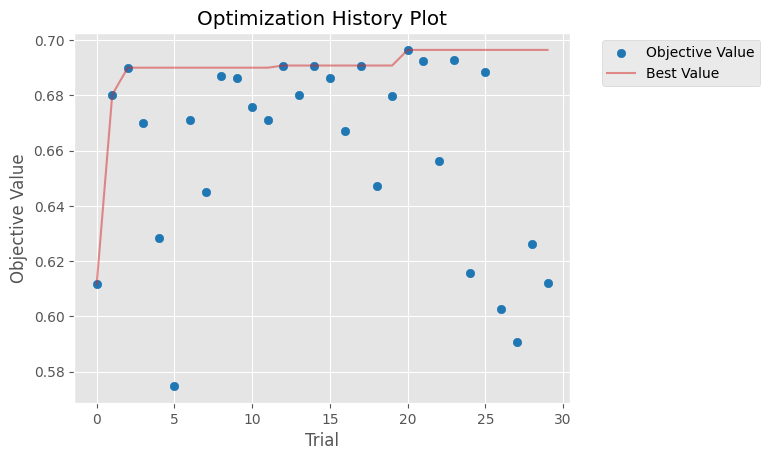

In [78]:
# Visualize optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_rf)
plt.show()

In [79]:
final_params_rf = dict(max_depth=best_rf_params['max_depth'], n_estimators = best_rf_params['n_estimators'],
                        max_features = best_rf_params['max_features'], criterion = best_rf_params['criterion'], min_samples_leaf = best_rf_params['min_samples_leaf'],
                        min_samples_split = best_rf_params['min_samples_split'], bootstrap = best_rf_params['bootstrap'])


In [80]:
# Istantiate the classifier with the best hyperparameters found
clf_tuned_rf = RandomForestClassifier(**final_params_rf, class_weight='balanced', random_state=42, n_jobs=-1)

In [81]:
# Fit the model
clf_tuned_rf.fit(X_trainval, y_trainval)

[codecarbon INFO @ 21:18:56] Energy consumed for RAM : 0.005081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:18:56] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:56] Energy consumed for All CPU : 0.021601 kWh
[codecarbon INFO @ 21:18:56] 0.026681 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:06] Energy consumed for RAM : 0.005108 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:06] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:06] Energy consumed for All CPU : 0.021719 kWh
[codecarbon INFO @ 21:19:06] 0.026827 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:06] 0.003901 g.CO2eq/s mean an estimation of 123.01652379507644 kg.CO2eq/year


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='log_loss', max_depth=3, min_samples_leaf=6,
                       min_samples_split=12, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [82]:
# Define the evaluate_model() function

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]  # Keep only probabilities for class 1

    # Define the Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Print the output
    print("\n Binary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create the figure to plot the Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

     # Create the figure to plot the ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

[codecarbon INFO @ 21:19:26] Energy consumed for RAM : 0.005164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:26] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:26] Energy consumed for All CPU : 0.021955 kWh
[codecarbon INFO @ 21:19:26] 0.027119 kWh of electricity used since the beginning.


FINAL RANDOM FOREST MODEL EVALUATION ON TEST SET

 Binary Classification Evaluation
Accuracy:             0.8025
Balanced Accuracy:    0.8527
Precision:            0.5455
Recall (Sensitivity): 0.9474
F1 Score:             0.6923
Log Loss:             0.4461
Brier Score:          0.1472
AUC-ROC:              0.8701

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.98      0.76      0.85        62
    Demented       0.55      0.95      0.69        19

    accuracy                           0.80        81
   macro avg       0.76      0.85      0.77        81
weighted avg       0.88      0.80      0.82        81



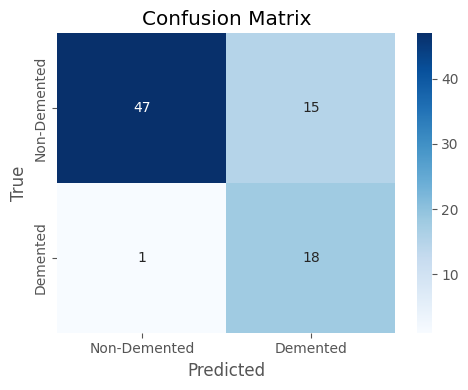

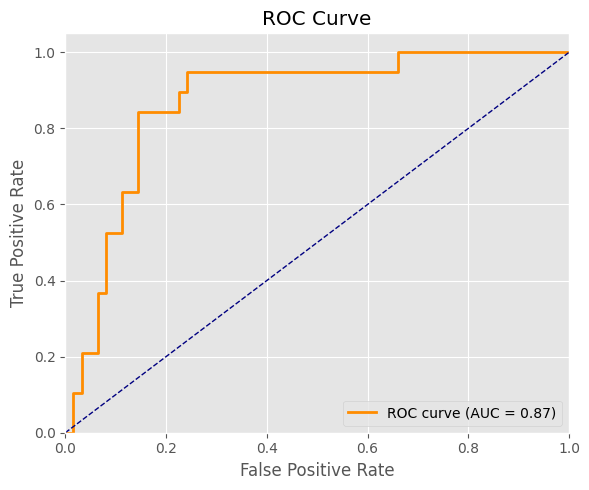

In [83]:
# Make predictions on the Test Set
X_test = pd.DataFrame(X_test, columns=clf_tuned_rf.feature_names_in_)

y_test_pred = clf_tuned_rf.predict(X_test)  # Class labels (0/1)
y_test_proba = clf_tuned_rf.predict_proba(X_test)[:, 1]  # Prob for class 1 (Demented)

# Compute the metrics, plot the confusion matrix and the ROC curve
print("FINAL RANDOM FOREST MODEL EVALUATION ON TEST SET")

test_metrics = evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])
plt.savefig("confusion_matrix_default_threshold.png", dpi=300)
plt.close()

[codecarbon INFO @ 21:19:36] Energy consumed for RAM : 0.005192 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:36] Delta energy consumed for CPU with constant : 0.000117 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:36] Energy consumed for All CPU : 0.022072 kWh
[codecarbon INFO @ 21:19:36] 0.027264 kWh of electricity used since the beginning.


EVALUATION WITH OPTIMAL THRESHOLD (0.6568)

 Binary Classification Evaluation
Accuracy:             0.8519
Balanced Accuracy:    0.8485
Precision:            0.6400
Recall (Sensitivity): 0.8421
F1 Score:             0.7273
Log Loss:             0.4461
Brier Score:          0.1472
AUC-ROC:              0.8701

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.95      0.85      0.90        62
    Demented       0.64      0.84      0.73        19

    accuracy                           0.85        81
   macro avg       0.79      0.85      0.81        81
weighted avg       0.87      0.85      0.86        81



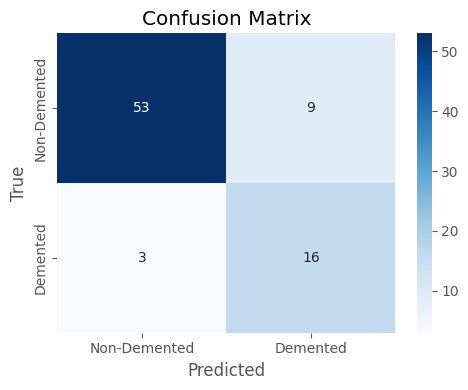

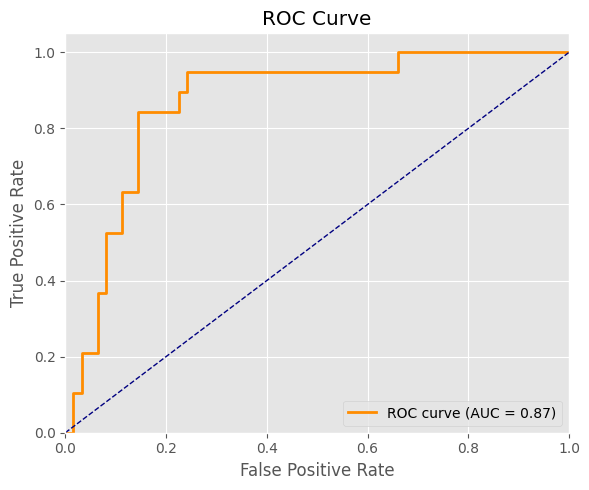

In [84]:
# Compute the metrics, plot the confusion matrix with the optimal threshold based on F1 score, and the ROC curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"EVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

evaluate_model(y_true=y_test, y_pred=y_test_pred_optimal, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])
plt.savefig("confusion_matrix_optimal_threshold.png", dpi=300)
plt.close()

In [85]:
tracker.stop()

[codecarbon INFO @ 21:19:44] Energy consumed for RAM : 0.005212 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:44] Delta energy consumed for CPU with constant : 0.000089 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:44] Energy consumed for All CPU : 0.022161 kWh
[codecarbon INFO @ 21:19:44] 0.027374 kWh of electricity used since the beginning.


0.007325806970188838

In [86]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Convert the emissions CSV to Excel and save it in the folder
csv_path = os.path.join(output_folder, "RF_emissions.csv")
excel_path = os.path.join(output_folder, "RF_emissions.xlsx")

df = pd.read_csv(csv_path)
df.to_excel(excel_path, index=False)

**CNN+XGBOOST**

In [109]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import optuna
import cv2
import warnings
from tensorflow.keras import layers, models, Input, Model
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [110]:
# Import the necessary libraries
import nibabel as nib
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns


In [111]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [112]:
# Fetch the Oasis VBM dataset
oasis_data=nilearn.datasets.fetch_oasis_vbm(n_subjects=None, dartel_version=True, data_dir=None, url=None, resume=True, verbose=1)


[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

In [113]:
# Load the DataFrame with clinical and demographic variables
ext_vars = pd.DataFrame(oasis_data['ext_vars'])

In [114]:
# Suppress warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [115]:
img_size = 64

# Load 2D slice extraction
def extract_2d_slice_from_nifti(paths, img_size):
    slices = []
    for path in paths:
        img_3d = load_img(path).get_fdata()
        if img_3d.ndim == 3:
            z_center = img_3d.shape[2] // 2
            img_2d = img_3d[:, :, z_center]
            img_resized = cv2.resize(img_2d, (img_size, img_size), interpolation=cv2.INTER_AREA)
            slices.append(img_resized)
    return np.array(slices)

# Load images and 'cdr' scores
X = extract_2d_slice_from_nifti(oasis_data['gray_matter_maps'], img_size)

# Standardize each image
X = np.array([(img - np.mean(img)) / (np.std(img) + 1e-8) for img in X], dtype=np.float32)

# Convert 'cdr' into a binary variable (0.0 == 0, 0.5/1.0/2.0 == 1)
ext_vars['cdr'] = ext_vars['cdr'].apply(lambda x: 0 if x == 0.0 else 1).astype(int)
y = ext_vars['cdr'].values
X = X[..., np.newaxis]  # Add channel

In [123]:
# Split the data into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the train+val set into separate train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)


In [124]:
# Build the CNN+XGBoost Model
def build_cnn_model(n_filters1, n_filters2, input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(n_filters1, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(n_filters2, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten(name='flatten_layer')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the Feature Extractor
def create_feature_extractor(trained_model):
    return Model(inputs=trained_model.input,
                 outputs=trained_model.get_layer('flatten_layer').output)


In [125]:
# Extract features from the CNN using the feature extractor
def extract_features(model, X):
    feature_extractor = create_feature_extractor(model)
    return feature_extractor.predict(X, verbose=0)

In [126]:
# GPU availability check
def get_tree_method():
    try:
        import xgboost
        if xgboost.rabit.get_num_processes() > 0:
            return "gpu_hist"
        import pynvml
        pynvml.nvmlInit()
        device_count = pynvml.nvmlDeviceGetCount()
        if device_count > 0:
            return "gpu_hist"
    except:
        pass
    return "hist"

In [127]:
# Initialize the Tracker
tracker = OfflineEmissionsTracker(output_dir="/content/drive/MyDrive/codecarbon_results/", output_file="CNN+XGBoost_emissions.csv", country_iso_code="NLD", measure_power_secs=10)
tracker.start()

[codecarbon INFO @ 22:05:42] offline tracker init
[codecarbon WARNING @ 22:05:42] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:05:42] [setup] RAM Tracking...
[codecarbon INFO @ 22:05:42] [setup] CPU Tracking...
[codecarbon WARNING @ 22:05:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 22:05:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:05:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 22:05:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:05:43] [setup] GPU Tracking...
[codecarbon INFO @ 22:05:43] No GPU found.
[codecarbon INFO @ 22:05:43] The below tracking methods have been set up:
                RAM Tracking 

In [128]:
# Define the Optuna objective function
def objective(trial):

    # CNN hyperparameters
    n_filters1 = trial.suggest_int("n_filters1", 22, 40, step=2)
    n_filters2 = trial.suggest_int("n_filters2", 24, 72, step=8)

    # XGBoost hyperparameters
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300, 400, 500])
    max_depth = trial.suggest_categorical("max_depth", [4, 6, 8, 10, 12])
    learning_rate = trial.suggest_categorical("learning_rate", [0.005, 0.01, 0.05, 0.1, 0.2])

    # Cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_accuracies = []

    for train_idx, val_idx in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Build and train the CNN
        cnn = build_cnn_model(n_filters1, n_filters2)
        cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = cnn.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=30, batch_size=32,
            verbose=0)

        # Extract the validation accuracy directly
        val_acc = history.history['val_accuracy'][-1]
        val_accuracies.append(val_acc)

        # Feature extraction
        X_fold_train_feat = extract_features(cnn, X_fold_train)
        X_fold_val_feat = extract_features(cnn, X_fold_val)

        # Check class balance
        if len(np.unique(y_fold_train)) < 2 or len(np.unique(y_fold_val)) < 2:
            raise optuna.exceptions.TrialPruned()

        # Fit XGBoost
        xgb_model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0,
            tree_method=get_tree_method(),
            n_jobs=-1)
        xgb_model.fit(X_fold_train_feat, y_fold_train)
    return np.mean(val_accuracies)


In [129]:
# Create the study and run the optimization
study = optuna.create_study(study_name='CNNXGBoost_hyperparameter_optimization', direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=1)
print("Best hyperparameters:", study.best_trial.params)

Streaming output truncated to the last 5000 lines.
[codecarbon INFO @ 02:09:53] 0.003900 g.CO2eq/s mean an estimation of 122.98415315349553 kg.CO2eq/year
[codecarbon INFO @ 02:10:03] Energy consumed for RAM : 0.040669 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:10:03] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 02:10:03] Energy consumed for All CPU : 0.172912 kWh
[codecarbon INFO @ 02:10:03] 0.213581 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:13] Energy consumed for RAM : 0.040697 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:10:13] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 02:10:13] Energy consumed for All CPU : 0.173030 kWh
[codecarbon INFO @ 02:10:13] 0.213727 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:23] Energy consumed for RAM : 0.040724 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:10:23] Delta energy consumed for CPU with 

Best hyperparameters: {'n_filters1': 36, 'n_filters2': 64, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.005}


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

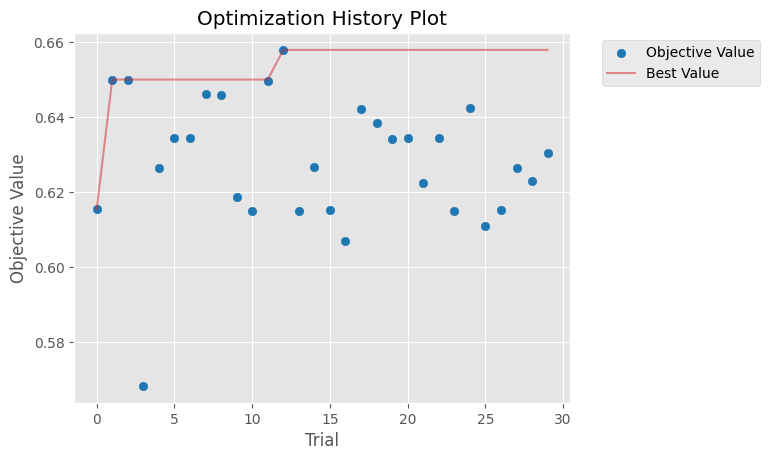

In [130]:
optuna.visualization.matplotlib.plot_optimization_history(study)


In [131]:
cnnxgboost_params = study.best_params
print(cnnxgboost_params)

{'n_filters1': 36, 'n_filters2': 64, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.005}


In [132]:
final_params_cnnxgboost = dict(n_filters1=cnnxgboost_params['n_filters1'], n_filters2 = cnnxgboost_params['n_filters2'],
                        n_estimators = cnnxgboost_params['n_estimators'], max_depth = cnnxgboost_params['max_depth'], learning_rate = cnnxgboost_params['learning_rate'])


In [133]:
# Re-define the CNN+XGBoost architecture
def build_cnn_model(n_filters1, n_filters2, input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(n_filters1, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(n_filters2, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten(name='flatten_layer')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Feature Extractor
def create_feature_extractor(trained_model):
    return Model(inputs=trained_model.input,
                 outputs=trained_model.get_layer('flatten_layer').output)


In [134]:
# Retrain the model with the best hyperparameters found
final_params_cnnxgboost = {
    'n_filters1': 36,
    'n_filters2': 64,
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.005}

cnn_final = build_cnn_model(final_params_cnnxgboost['n_filters1'], final_params_cnnxgboost['n_filters2'])
cnn_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_final.fit(X_trainval, y_trainval, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6091 - loss: 0.7585

[codecarbon INFO @ 05:38:46] Energy consumed for RAM : 0.075409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:38:46] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:38:47] Energy consumed for All CPU : 0.320620 kWh
[codecarbon INFO @ 05:38:47] 0.396029 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.5986 - loss: 0.7544 - val_accuracy: 0.7077 - val_loss: 0.6776
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 594ms/step - accuracy: 0.6871 - loss: 0.6685 - val_accuracy: 0.7077 - val_loss: 0.6063
Epoch 3/30


[codecarbon INFO @ 05:38:57] Energy consumed for RAM : 0.075437 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:38:57] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:38:57] Energy consumed for All CPU : 0.320738 kWh
[codecarbon INFO @ 05:38:57] 0.396175 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.6871 - loss: 0.6422 - val_accuracy: 0.7077 - val_loss: 0.6116
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.6871 - loss: 0.6214 - val_accuracy: 0.7077 - val_loss: 0.6038
Epoch 5/30


[codecarbon INFO @ 05:39:07] Energy consumed for RAM : 0.075464 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:39:07] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:39:07] Energy consumed for All CPU : 0.320856 kWh
[codecarbon INFO @ 05:39:07] 0.396321 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.6871 - loss: 0.6199 - val_accuracy: 0.7077 - val_loss: 0.6020
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.6871 - loss: 0.6133 - val_accuracy: 0.7077 - val_loss: 0.6009
Epoch 7/30
2/9 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.7422 - loss: 0.5718

[codecarbon INFO @ 05:39:17] Energy consumed for RAM : 0.075492 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:39:17] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:39:17] Energy consumed for All CPU : 0.320974 kWh
[codecarbon INFO @ 05:39:17] 0.396467 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - accuracy: 0.6871 - loss: 0.6103 - val_accuracy: 0.7077 - val_loss: 0.5974
Epoch 8/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6916 - loss: 0.6031

[codecarbon INFO @ 05:39:27] Energy consumed for RAM : 0.075520 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:39:27] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:39:27] Energy consumed for All CPU : 0.321092 kWh
[codecarbon INFO @ 05:39:27] 0.396612 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:39:27] 0.003901 g.CO2eq/s mean an estimation of 123.01048012901218 kg.CO2eq/year


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.6871 - loss: 0.6059 - val_accuracy: 0.7077 - val_loss: 0.5951
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 471ms/step - accuracy: 0.6893 - loss: 0.5989 - val_accuracy: 0.7077 - val_loss: 0.5920
Epoch 10/30


[codecarbon INFO @ 05:39:37] Energy consumed for RAM : 0.075548 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:39:37] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:39:37] Energy consumed for All CPU : 0.321210 kWh
[codecarbon INFO @ 05:39:37] 0.396758 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.6893 - loss: 0.5942 - val_accuracy: 0.7231 - val_loss: 0.5914
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.6881 - loss: 0.5864 - val_accuracy: 0.7231 - val_loss: 0.5861
Epoch 12/30
3/9 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - accuracy: 0.7500 - loss: 0.5535

[codecarbon INFO @ 05:39:47] Energy consumed for RAM : 0.075576 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:39:47] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:39:47] Energy consumed for All CPU : 0.321328 kWh
[codecarbon INFO @ 05:39:47] 0.396904 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - accuracy: 0.6974 - loss: 0.5788 - val_accuracy: 0.6923 - val_loss: 0.5885
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.6793 - loss: 0.5757 - val_accuracy: 0.7077 - val_loss: 0.5894
Epoch 14/30
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7160 - loss: 0.5659

[codecarbon INFO @ 05:39:57] Energy consumed for RAM : 0.075603 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:39:57] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:39:57] Energy consumed for All CPU : 0.321446 kWh
[codecarbon INFO @ 05:39:57] 0.397050 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.7053 - loss: 0.5661 - val_accuracy: 0.7385 - val_loss: 0.5891
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - accuracy: 0.7032 - loss: 0.5553 - val_accuracy: 0.7231 - val_loss: 0.5917
Epoch 16/30
6/9 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.6834 - loss: 0.5508

[codecarbon INFO @ 05:40:07] Energy consumed for RAM : 0.075631 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:40:07] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:40:07] Energy consumed for All CPU : 0.321565 kWh
[codecarbon INFO @ 05:40:07] 0.397196 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 654ms/step - accuracy: 0.6797 - loss: 0.5481 - val_accuracy: 0.7077 - val_loss: 0.5944
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.7300 - loss: 0.5364 - val_accuracy: 0.7231 - val_loss: 0.5911
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.7553 - loss: 0.5169 - val_accuracy: 0.7231 - val_loss: 0.5889
Epoch 19/30
5/9 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.7845 - loss: 0.5057

[codecarbon INFO @ 05:40:17] Energy consumed for RAM : 0.075659 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:40:17] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:40:17] Energy consumed for All CPU : 0.321683 kWh
[codecarbon INFO @ 05:40:17] 0.397341 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.7710 - loss: 0.5018 - val_accuracy: 0.6923 - val_loss: 0.5976
Epoch 20/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 583ms/step - accuracy: 0.7714 - loss: 0.4930 - val_accuracy: 0.6615 - val_loss: 0.6089
Epoch 21/30


[codecarbon INFO @ 05:40:27] Energy consumed for RAM : 0.075687 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:40:27] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:40:27] Energy consumed for All CPU : 0.321800 kWh
[codecarbon INFO @ 05:40:27] 0.397487 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.7718 - loss: 0.4826 - val_accuracy: 0.6769 - val_loss: 0.6104
Epoch 22/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - accuracy: 0.7862 - loss: 0.4643 - val_accuracy: 0.6462 - val_loss: 0.6102
Epoch 23/30


[codecarbon INFO @ 05:40:37] Energy consumed for RAM : 0.075714 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:40:37] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:40:37] Energy consumed for All CPU : 0.321918 kWh
[codecarbon INFO @ 05:40:37] 0.397633 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.7926 - loss: 0.4422 - val_accuracy: 0.6462 - val_loss: 0.6117
Epoch 24/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.8114 - loss: 0.4229 - val_accuracy: 0.6462 - val_loss: 0.6219
Epoch 25/30
3/9 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.7969 - loss: 0.4109

[codecarbon INFO @ 05:40:47] Energy consumed for RAM : 0.075742 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:40:47] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:40:47] Energy consumed for All CPU : 0.322037 kWh
[codecarbon INFO @ 05:40:47] 0.397779 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:40:47] 0.003900 g.CO2eq/s mean an estimation of 122.98711089596972 kg.CO2eq/year


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - accuracy: 0.8058 - loss: 0.4096 - val_accuracy: 0.6308 - val_loss: 0.6258
Epoch 26/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 428ms/step - accuracy: 0.8157 - loss: 0.3905 - val_accuracy: 0.6154 - val_loss: 0.6395
Epoch 27/30
6/9 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.7982 - loss: 0.3830

[codecarbon INFO @ 05:40:57] Energy consumed for RAM : 0.075770 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:40:57] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:40:57] Energy consumed for All CPU : 0.322155 kWh
[codecarbon INFO @ 05:40:57] 0.397925 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.8110 - loss: 0.3764 - val_accuracy: 0.6308 - val_loss: 0.6369
Epoch 28/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.8317 - loss: 0.3518 - val_accuracy: 0.6000 - val_loss: 0.6513
Epoch 29/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 583ms/step - accuracy: 0.8468 - loss: 0.3350 - val_accuracy: 0.6308 - val_loss: 0.6192
Epoch 30/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 5s 628ms/step - accuracy: 0.9375 - loss: 0.2739

[codecarbon INFO @ 05:41:07] Energy consumed for RAM : 0.075798 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:41:07] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:41:07] Energy consumed for All CPU : 0.322273 kWh
[codecarbon INFO @ 05:41:07] 0.398071 kWh of electricity used since the beginning.


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 0.8934 - loss: 0.2904 - val_accuracy: 0.6923 - val_loss: 0.6245


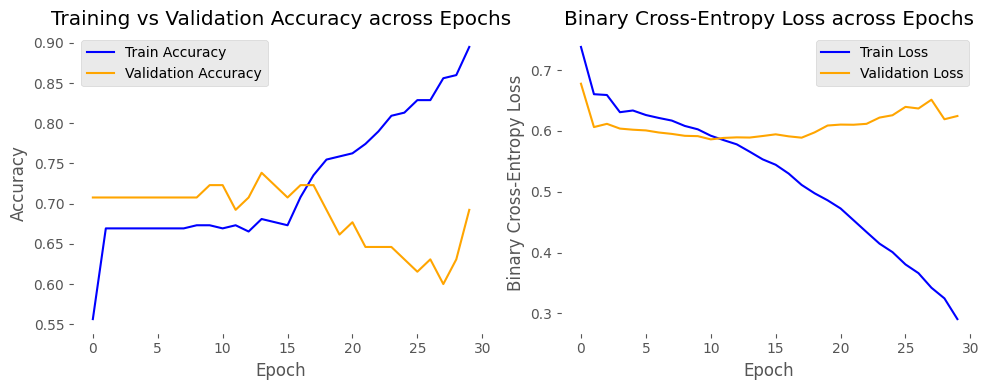

In [135]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy
fig = plt.figure(figsize=(10, 4), facecolor='white')

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy across Epochs')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('white')

# Plot Binary Cross-Entropy Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Binary Cross-Entropy Loss across Epochs')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig("cnn_training_plots.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()


In [136]:
# Extract the Features from the CNN to make the final classification using XGBoost
feature_extractor_final = create_feature_extractor(cnn_final)
X_trainval_feat = feature_extractor_final.predict(X_trainval, batch_size=32, verbose=0)
X_test_feat = feature_extractor_final.predict(X_test, batch_size=32, verbose=0)

# Train the final XGBoost Classifier
xgb_final = XGBClassifier(
    n_estimators=final_params_cnnxgboost['n_estimators'],
    max_depth=final_params_cnnxgboost['max_depth'],
    learning_rate=final_params_cnnxgboost['learning_rate'],
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=1,
    tree_method=get_tree_method(),
    n_jobs=-1)

xgb_final.fit(X_trainval_feat, y_trainval)

[codecarbon INFO @ 05:43:37] Energy consumed for RAM : 0.076214 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:43:37] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:43:37] Energy consumed for All CPU : 0.324043 kWh
[codecarbon INFO @ 05:43:37] 0.400257 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:43:47] Energy consumed for RAM : 0.076242 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:43:47] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:43:47] Energy consumed for All CPU : 0.324161 kWh
[codecarbon INFO @ 05:43:47] 0.400403 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:43:57] Energy consumed for RAM : 0.076270 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:43:57] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 05:43:57] Energy consumed for All CPU : 0.324279 kWh
[codecarbon INFO @ 05:43:57] 0.400549 kWh 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [137]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute the Evaluation Metrics and print them
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    print("\n Binary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Build the Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot the ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

FINAL CNN + XGBOOST MODEL EVALUATION ON TEST SET

 Binary Classification Evaluation
Accuracy:             0.6790
Balanced Accuracy:    0.5000
Precision:            0.6790
Recall (Sensitivity): 1.0000
F1 Score:             0.8088
Log Loss:             0.5769
Brier Score:          0.1956
AUC-ROC:              0.7514

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.00      0.00      0.00        26
    Demented       0.68      1.00      0.81        55

    accuracy                           0.68        81
   macro avg       0.34      0.50      0.40        81
weighted avg       0.46      0.68      0.55        81



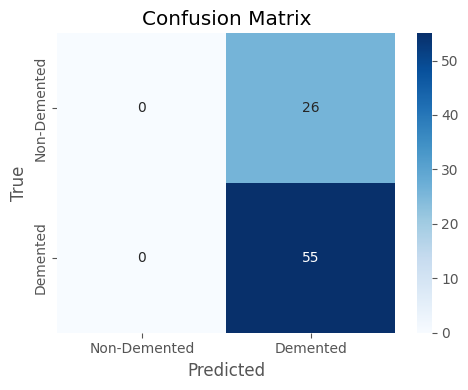

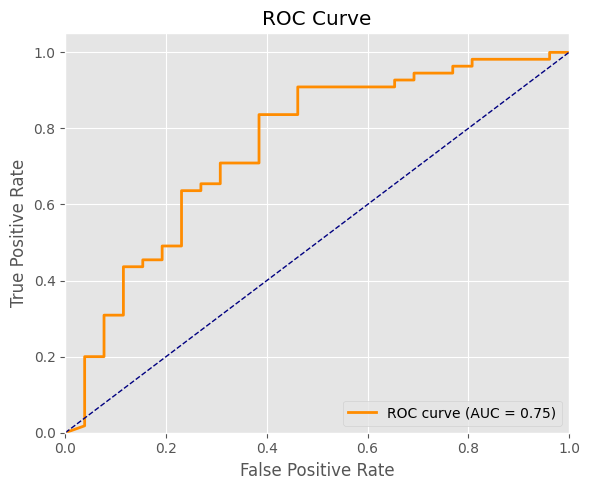

In [138]:
# Predict on the test set using XGBoost
y_test_pred = xgb_final.predict(X_test_feat)  # Predicted class labels (0/1)
y_test_proba = xgb_final.predict_proba(X_test_feat)[:, 1]  # Probabilities for class 1 (Demented)

# Print header
print("FINAL CNN + XGBOOST MODEL EVALUATION ON TEST SET")

# Evaluate and visualize
evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("confusion_matrix_default_threshold.png", dpi=300)
plt.close()


EVALUATION WITH OPTIMAL THRESHOLD (0.6151)

 Binary Classification Evaluation
Accuracy:             0.7901
Balanced Accuracy:    0.7238
Precision:            0.8065
Recall (Sensitivity): 0.9091
F1 Score:             0.8547
Log Loss:             0.5769
Brier Score:          0.1956
AUC-ROC:              0.7514

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.74      0.54      0.62        26
    Demented       0.81      0.91      0.85        55

    accuracy                           0.79        81
   macro avg       0.77      0.72      0.74        81
weighted avg       0.78      0.79      0.78        81



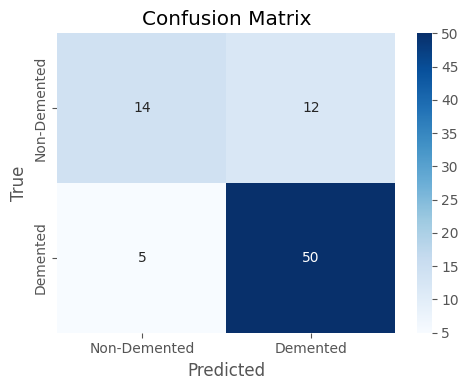

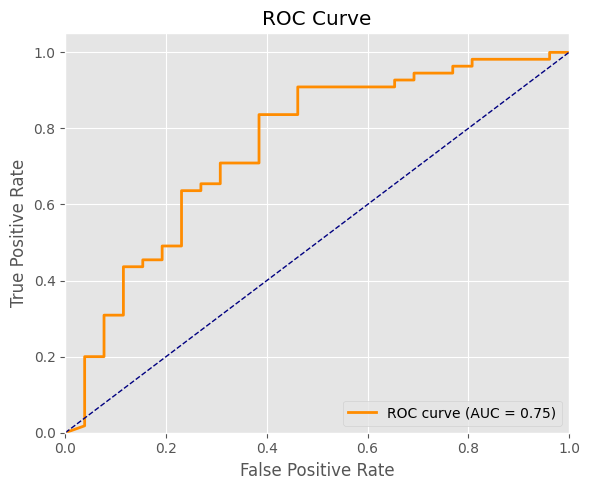

In [139]:
# Get the predicted probabilities for the positive class (Demented)
y_test_proba = xgb_final.predict_proba(X_test_feat)[:, 1]

# Compute the optimal threshold based on F1 score
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nEVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

# Convert probabilities to binary predictions based on optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate model performance with optimal threshold
evaluate_model(y_true=y_test, y_pred=y_test_pred_optimal, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("confusion_matrix_optimal_threshold.png", dpi=300)
plt.close()

In [140]:
tracker.stop()

[codecarbon INFO @ 05:46:20] Energy consumed for RAM : 0.076669 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:46:20] Delta energy consumed for CPU with constant : 0.000044 kWh, power : 42.5 W
[codecarbon INFO @ 05:46:20] Energy consumed for All CPU : 0.325976 kWh
[codecarbon INFO @ 05:46:20] 0.402645 kWh of electricity used since the beginning.


0.10775655216048759

In [141]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Convert the emissions CSV to Excel and save it in the folder
csv_path = os.path.join(output_folder, "CNN+XGBoost_emissions.csv")
excel_path = os.path.join(output_folder, "CNN+XGBoost_emissions.xlsx")

df = pd.read_csv(csv_path)
df.to_excel(excel_path, index=False)

**Pre-Trained DenseNet+SVM**

In [9]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.6 MB/s eta 0:00:00


In [10]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [11]:
# Import libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import optuna
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [14]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load Oasis 1 Dataset
dataset = nilearn.datasets.fetch_oasis_vbm(n_subjects=None, dartel_version=True)
images = dataset.gray_matter_maps
labels = np.where(dataset.ext_vars['cdr'].astype(float) > 0, 1, 0)  # 1: Demented, 0: Non-demented

# Initial Split (before Standardization)
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)


Using device: cpu


[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

In [15]:
# Load Images as flattened vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-score normalization using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

100%|██████████| 81/81 [00:02<00:00, 39.18it/s]


In [16]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)  # shape: (1, 91, 109, 91)
        return img_tensor, self.labels[idx]

train_dataset = OASISDataset(X_train_flat, y_train)
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)

In [17]:
import os
from codecarbon import EmissionsTracker

# Ensure the output folder exists
output_folder = "/content/drive/MyDrive/codecarbon_results/"
os.makedirs(output_folder, exist_ok=True)

In [18]:
from codecarbon import OfflineEmissionsTracker

# Initialize the Tracker
tracker = OfflineEmissionsTracker(output_dir="/content/drive/MyDrive/codecarbon_results/", output_file="DenseNet+SVM_emissions.csv", country_iso_code="NLD", measure_power_secs=10)
tracker.start()

[codecarbon INFO @ 12:21:36] offline tracker init
[codecarbon WARNING @ 12:21:36] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:21:36] [setup] RAM Tracking...
[codecarbon INFO @ 12:21:36] [setup] CPU Tracking...
[codecarbon WARNING @ 12:21:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:21:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:21:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:21:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:21:38] [setup] GPU Tracking...
[codecarbon INFO @ 12:21:38] No GPU found.
[codecarbon INFO @ 12:21:38] The below tracking methods have been set up:
                RAM Tracking 

In [21]:
#import shutil
#shutil.copy("/content/drive/MyDrive/brainage_densenet/densenet.py", "/content/")


'/content/densenet.py'

In [22]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

  0%|          | 0/65 [00:00<?, ?it/s][codecarbon INFO @ 12:27:38] Energy consumed for RAM : 0.001000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:27:38] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 12:27:38] Energy consumed for All CPU : 0.004249 kWh
[codecarbon INFO @ 12:27:38] 0.005249 kWh of electricity used since the beginning.
  2%|▏         | 1/65 [00:05<06:13,  5.84s/it][codecarbon INFO @ 12:27:48] Energy consumed for RAM : 0.001027 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:27:48] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 12:27:48] Energy consumed for All CPU : 0.004367 kWh
[codecarbon INFO @ 12:27:48] 0.005395 kWh of electricity used since the beginning.
  5%|▍         | 3/65 [00:13<04:30,  4.37s/it][codecarbon INFO @ 12:27:58] Energy consumed for RAM : 0.001055 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:27:58] Delta energy consumed for CPU with constant : 0.000118 kWh,

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Optuna Objective function and the hyperparameters

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])
    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    return scores.mean()

In [24]:
import optuna
import logging

# Suppress Optuna INFO and DEBUG logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the optimization
study_densenetsvm = optuna.create_study(direction="maximize")
study_densenetsvm.optimize(objective, n_trials=30)
print("Best SVM Params:", study_densenetsvm.best_params)

[codecarbon INFO @ 12:37:28] Energy consumed for RAM : 0.002638 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:37:28] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:28] Energy consumed for All CPU : 0.011215 kWh
[codecarbon INFO @ 12:37:28] 0.013853 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:38] Energy consumed for RAM : 0.002666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:37:38] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:38] Energy consumed for All CPU : 0.011333 kWh
[codecarbon INFO @ 12:37:38] 0.013999 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:38] 0.003901 g.CO2eq/s mean an estimation of 123.02222858274615 kg.CO2eq/year
[codecarbon INFO @ 12:37:48] Energy consumed for RAM : 0.002694 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:37:48] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon

Best SVM Params: {'kernel': 'linear', 'C': 1, 'gamma': 0.1}


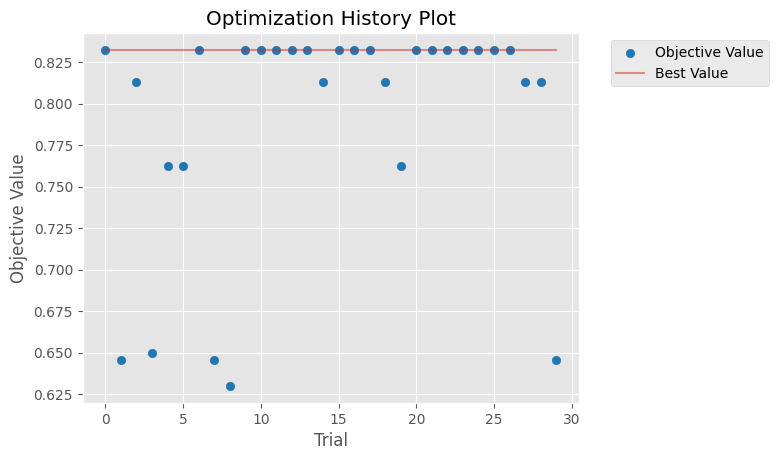

In [25]:
import warnings
import optuna.visualization.matplotlib as vis_matplotlib

# Suppress warning and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm)

# Save the figure
fig = ax.figure
fig.savefig("optuna_optimization_history_densenetsvm.png", dpi=300, bbox_inches='tight')

In [26]:
densenetsvm_params = study_densenetsvm.best_params
print(densenetsvm_params)

{'kernel': 'linear', 'C': 1, 'gamma': 0.1}


In [27]:
final_params_densenetsvm = dict(kernel=densenetsvm_params['kernel'], C= densenetsvm_params['C'], gamma = densenetsvm_params['gamma'])

In [28]:
# Combine train and val sets
X_trainval = np.concatenate([X_train_flat, X_val_flat], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# Define the final SVM with best hyperparameters
model = SVC(kernel='linear', C=1, gamma=0.1, probability=True)

# Train the algorithm on combined train+val set
model.fit(X_trainval, y_trainval)

[codecarbon INFO @ 12:47:48] Energy consumed for RAM : 0.004360 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:47:48] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:48] Energy consumed for All CPU : 0.018533 kWh
[codecarbon INFO @ 12:47:48] 0.022893 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:47:58] Energy consumed for RAM : 0.004387 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:47:58] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:58] Energy consumed for All CPU : 0.018651 kWh
[codecarbon INFO @ 12:47:58] 0.023039 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:48:08] Energy consumed for RAM : 0.004415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:48:08] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:08] Energy consumed for All CPU : 0.018770 kWh
[codecarbon INFO @ 12:48:08] 0.023185 kWh 

SVC(C=1, gamma=0.1, kernel='linear', probability=True)

In [29]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the evaluate_model() function to compute the evaluation metrics and create the plots

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    print("\nBinary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # ROC Curve plot
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

[codecarbon INFO @ 13:00:59] Energy consumed for RAM : 0.006553 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:00:59] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:00:59] Energy consumed for All CPU : 0.027858 kWh
[codecarbon INFO @ 13:00:59] 0.034411 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:09] Energy consumed for RAM : 0.006581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:01:09] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:01:09] Energy consumed for All CPU : 0.027977 kWh
[codecarbon INFO @ 13:01:09] 0.034557 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:19] Energy consumed for RAM : 0.006609 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:01:19] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:01:19] Energy consumed for All CPU : 0.028095 kWh
[codecarbon INFO @ 13:01:19] 0.034703 kWh 

FINAL SVM MODEL EVALUATION ON TEST SET

Binary Classification Evaluation
Accuracy:             0.8519
Balanced Accuracy:    0.7937
Precision:            0.6842
Recall (Sensitivity): 0.6842
F1 Score:             0.6842
Log Loss:             0.3932
Brier Score:          0.1185
AUC-ROC:              0.8913

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.90      0.90      0.90        62
    Demented       0.68      0.68      0.68        19

    accuracy                           0.85        81
   macro avg       0.79      0.79      0.79        81
weighted avg       0.85      0.85      0.85        81



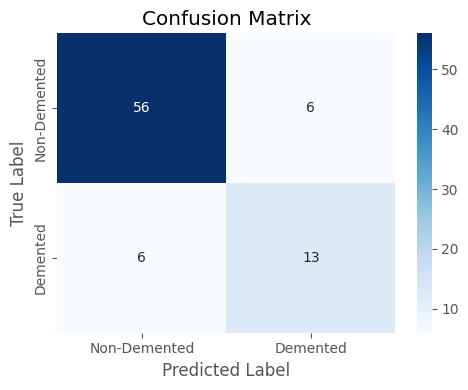

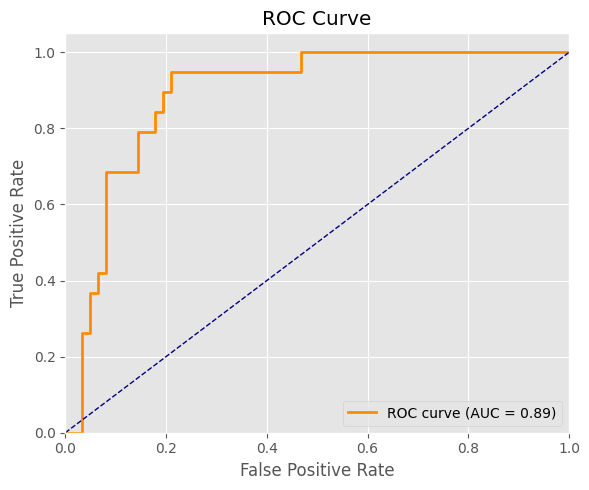

In [30]:
# Predict on the test set
y_test_pred = model.predict(X_test_flat)
y_test_proba = model.predict_proba(X_test_flat)[:, 1]  # Probabilities for class 1 (Demented)

# Print header
print("FINAL SVM MODEL EVALUATION ON TEST SET")

# Evaluate and visualize
evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("confusion_matrix_svm_default_threshold.png", dpi=300)
plt.close()

[codecarbon INFO @ 13:01:59] Energy consumed for RAM : 0.006720 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:01:59] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:01:59] Energy consumed for All CPU : 0.028567 kWh
[codecarbon INFO @ 13:01:59] 0.035287 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:09] Energy consumed for RAM : 0.006747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:02:09] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:02:09] Energy consumed for All CPU : 0.028685 kWh
[codecarbon INFO @ 13:02:09] 0.035432 kWh of electricity used since the beginning.



EVALUATION WITH OPTIMAL THRESHOLD (0.1963)

Binary Classification Evaluation
Accuracy:             0.8272
Balanced Accuracy:    0.8688
Precision:            0.5806
Recall (Sensitivity): 0.9474
F1 Score:             0.7200
Log Loss:             0.3932
Brier Score:          0.1185
AUC-ROC:              0.8913

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.98      0.79      0.88        62
    Demented       0.58      0.95      0.72        19

    accuracy                           0.83        81
   macro avg       0.78      0.87      0.80        81
weighted avg       0.89      0.83      0.84        81



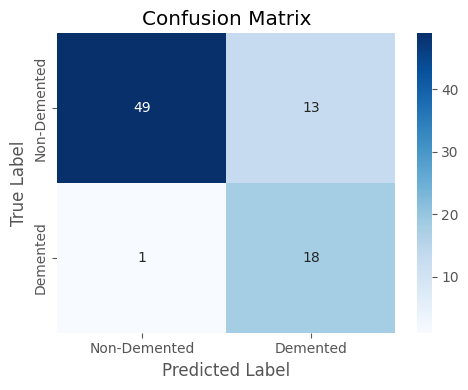

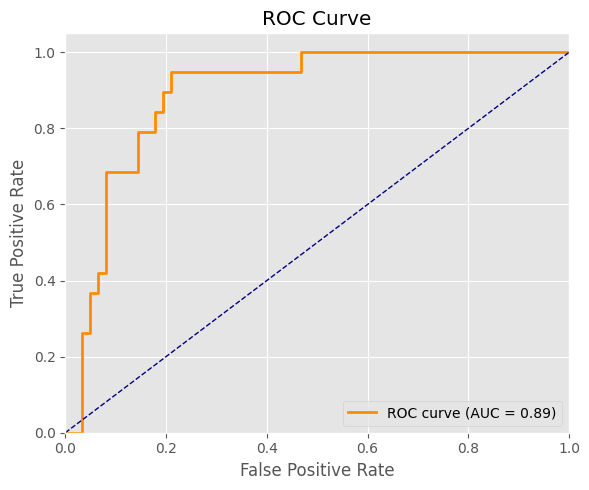

In [31]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get the predicted probabilities for the positive class (Demented)
y_test_proba = model.predict_proba(X_test_flat)[:, 1]

# Compute the optimal threshold based on F1 score
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nEVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

# Convert probabilities to binary predictions based on optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate model performance with optimal threshold
evaluate_model(y_true=y_test, y_pred=y_test_pred_optimal, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("confusion_matrix_svm_optimal_threshold.png", dpi=300)
plt.close()

In [32]:
tracker.stop()

[codecarbon INFO @ 13:02:52] Energy consumed for RAM : 0.006868 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:02:52] Delta energy consumed for CPU with constant : 0.000039 kWh, power : 42.5 W
[codecarbon INFO @ 13:02:52] Energy consumed for All CPU : 0.029196 kWh
[codecarbon INFO @ 13:02:52] 0.036063 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:52] 0.003901 g.CO2eq/s mean an estimation of 123.00915180293944 kg.CO2eq/year


0.009651381585813513

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Convert the emissions CSV to Excel and save it in the Google Drive folder
csv_path = os.path.join(output_folder, "DenseNet+SVM_emissions.csv")
excel_path = os.path.join(output_folder, "DenseNet+SVM_emissions.xlsx")

df = pd.read_csv(csv_path)
df.to_excel(excel_path, index=False)

**Unet+AdaBoost**

In [35]:
# Import libraries
import numpy as np
import nibabel as nib
import cv2
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout,
                                     UpSampling2D, concatenate, GlobalAveragePooling2D, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from nilearn.datasets import fetch_oasis_vbm
import tensorflow as tf

In [36]:
from nilearn.datasets import fetch_oasis_vbm
from sklearn.metrics import (classification_report, precision_score, recall_score, f1_score, balanced_accuracy_score, brier_score_loss, log_loss, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.layers import Flatten

In [37]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [38]:
# Load the dataset and preprocess ext_vars
dataset=nilearn.datasets.fetch_oasis_vbm(n_subjects=None, dartel_version=True, data_dir=None, url=None, resume=True, verbose=1)
metadata = dataset.ext_vars

metadata = metadata[metadata['cdr'].notna()].copy()
metadata['cdr'] = metadata['cdr'].astype(float)
metadata['demented'] = (metadata['cdr'] > 0).astype(int)

metadata = metadata.iloc[:len(dataset.gray_matter_maps)].reset_index(drop=True)

[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

In [39]:
# Preprocess and standardize each MRI slice
def preprocess(df):
    X, y = [], []
    for idx in df.index:
        label = df.loc[idx, 'demented']
        img_path = dataset.gray_matter_maps[idx]

        img = nib.load(img_path)
        data = img.get_fdata()
        slice_ = data[:, :, data.shape[2] // 2]    # take middle axial slice

        # Z-score normalization
        mean = np.mean(slice_)
        std = np.std(slice_)
        if std == 0: std = 1e-8                    # avoid division by zero
        slice_zscore = (slice_ - mean) / std

        # Only accept slices with expected shape
        if slice_zscore.shape == (91, 109):
            X.append(slice_zscore[..., np.newaxis])    # add channel dim
            y.append(label)

    return np.array(X), np.array(y)

# Resize standardized slices
def resize_images(X, new_shape=(256, 256)):
    resized_X = []
    for img in X:
        img_resized = cv2.resize(img.squeeze(), new_shape, interpolation=cv2.INTER_AREA)
        resized_X.append(img_resized[..., np.newaxis])  # restore channel dim
    return np.array(resized_X)

# Apply preprocessing
X, y = preprocess(metadata)
X_resized = resize_images(X)

In [40]:
# Split the data
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [41]:
import os
from codecarbon import EmissionsTracker

# Ensure the output folder exists
output_folder = "/content/drive/MyDrive/codecarbon_results/"
os.makedirs(output_folder, exist_ok=True)

In [42]:
# Initialize the Tracker
tracker = OfflineEmissionsTracker(output_dir="/content/drive/MyDrive/codecarbon_results/", output_file="Unet+AdaBoost_emissions.csv", country_iso_code="NLD", measure_power_secs=10)
tracker.start()

[codecarbon INFO @ 13:39:43] offline tracker init
[codecarbon WARNING @ 13:39:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:39:43] [setup] RAM Tracking...
[codecarbon INFO @ 13:39:43] [setup] CPU Tracking...
[codecarbon WARNING @ 13:39:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:39:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:39:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:39:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:39:44] [setup] GPU Tracking...
[codecarbon INFO @ 13:39:44] No GPU found.
[codecarbon INFO @ 13:39:44] The below tracking methods have been set up:
                RAM Tracking 

In [43]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

def improved_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting path
    c1 = Conv2D(16, 3, padding='same')(inputs)
    c1 = LeakyReLU(negative_slope=0.01)(c1)
    c1 = Conv2D(16, 3, padding='same')(c1)
    c1 = LeakyReLU(negative_slope=0.01)(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, padding='same')(p1)
    c2 = LeakyReLU(negative_slope=0.01)(c2)
    c2 = Conv2D(32, 3, padding='same')(c2)
    c2 = LeakyReLU(negative_slope=0.01)(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, padding='same')(p2)
    c3 = LeakyReLU(negative_slope=0.01)(c3)
    c3 = Conv2D(64, 3, padding='same')(c3)
    c3 = LeakyReLU(negative_slope=0.01)(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(128, 3, padding='same')(p3)
    c4 = LeakyReLU(negative_slope=0.01)(c4)
    c4 = Conv2D(128, 3, padding='same')(c4)
    c4 = LeakyReLU(negative_slope=0.01)(c4)

    gap = GlobalAveragePooling2D()(c4)
    output = Dense(1, activation='sigmoid')(gap)

    model = Model(inputs, output)
    feature_extractor = Model(inputs=inputs, outputs=c4)  # output features

    return model, feature_extractor

# Instantiate the model and feature_extractor
input_shape = (256, 256, 1)
model, feature_extractor = improved_unet(input_shape)

# Show model architecture summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,361 (1.12 MB)

 Trainable params: 293,361 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Compute class weights to counteract the class imbalance in the dataset. This step is necessary to improve the model training that follows

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [45]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Build and compile the model
model, feature_extractor = improved_unet((256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[early_stop], class_weight=class_weights_dict, verbose=1)



Epoch 1/30


[codecarbon INFO @ 13:41:44] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:41:44] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:41:44] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 13:41:44] 0.001750 kWh of electricity used since the beginning.


1/5 ━━━━━━━━━━━━━━━━━━━━ 45s 11s/step - accuracy: 0.6562 - loss: 0.6744

[codecarbon INFO @ 13:41:54] Energy consumed for RAM : 0.000361 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:41:54] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:41:54] Energy consumed for All CPU : 0.001535 kWh
[codecarbon INFO @ 13:41:54] 0.001896 kWh of electricity used since the beginning.


2/5 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.6484 - loss: 0.6754 

[codecarbon INFO @ 13:42:04] Energy consumed for RAM : 0.000389 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:42:04] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:42:04] Energy consumed for All CPU : 0.001653 kWh
[codecarbon INFO @ 13:42:04] 0.002042 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.6302 - loss: 0.6817

[codecarbon INFO @ 13:42:14] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:42:14] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:42:14] Energy consumed for All CPU : 0.001771 kWh
[codecarbon INFO @ 13:42:14] 0.002188 kWh of electricity used since the beginning.


4/5 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.6172 - loss: 0.6856 

[codecarbon INFO @ 13:42:24] Energy consumed for RAM : 0.000444 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:42:24] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:42:24] Energy consumed for All CPU : 0.001889 kWh
[codecarbon INFO @ 13:42:24] 0.002334 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:42:24] 0.003901 g.CO2eq/s mean an estimation of 123.01322344757055 kg.CO2eq/year


5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.6036 - loss: 0.6894 - val_accuracy: 0.4167 - val_loss: 0.6943
Epoch 2/30


[codecarbon INFO @ 13:42:34] Energy consumed for RAM : 0.000472 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:42:34] Delta energy consumed for CPU with constant : 0.000119 kWh, power : 42.5 W
[codecarbon INFO @ 13:42:34] Energy consumed for All CPU : 0.002008 kWh
[codecarbon INFO @ 13:42:34] 0.002480 kWh of electricity used since the beginning.


1/5 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - accuracy: 0.3438 - loss: 0.6769

[codecarbon INFO @ 13:42:44] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:42:44] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:42:44] Energy consumed for All CPU : 0.002126 kWh
[codecarbon INFO @ 13:42:44] 0.002626 kWh of electricity used since the beginning.


2/5 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.3516 - loss: 0.6784

[codecarbon INFO @ 13:42:54] Energy consumed for RAM : 0.000528 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:42:54] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:42:54] Energy consumed for All CPU : 0.002244 kWh
[codecarbon INFO @ 13:42:54] 0.002772 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.3698 - loss: 0.6822

[codecarbon INFO @ 13:43:04] Energy consumed for RAM : 0.000556 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:04] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:04] Energy consumed for All CPU : 0.002362 kWh
[codecarbon INFO @ 13:43:04] 0.002918 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3910 - loss: 0.6866

[codecarbon INFO @ 13:43:14] Energy consumed for RAM : 0.000583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:14] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:14] Energy consumed for All CPU : 0.002480 kWh
[codecarbon INFO @ 13:43:14] 0.003064 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.3964 - loss: 0.6878 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 3/30


[codecarbon INFO @ 13:43:24] Energy consumed for RAM : 0.000611 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:24] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:24] Energy consumed for All CPU : 0.002598 kWh
[codecarbon INFO @ 13:43:24] 0.003209 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:34] Energy consumed for RAM : 0.000639 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:34] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:34] Energy consumed for All CPU : 0.002716 kWh
[codecarbon INFO @ 13:43:34] 0.003355 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:44] Energy consumed for RAM : 0.000667 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:44] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:44] Energy consumed for All CPU : 0.002834 kWh
[codecarbon INFO @ 13:43:44] 0.003501 kWh 

1/5 ━━━━━━━━━━━━━━━━━━━━ 3:07 47s/step - accuracy: 0.3438 - loss: 0.6763

[codecarbon INFO @ 13:44:15] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:44:15] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:44:15] Energy consumed for All CPU : 0.003189 kWh
[codecarbon INFO @ 13:44:15] 0.003939 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.3698 - loss: 0.6818 

[codecarbon INFO @ 13:44:25] Energy consumed for RAM : 0.000778 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:44:25] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:44:25] Energy consumed for All CPU : 0.003307 kWh
[codecarbon INFO @ 13:44:25] 0.004085 kWh of electricity used since the beginning.


4/5 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3828 - loss: 0.6846 

[codecarbon INFO @ 13:44:35] Energy consumed for RAM : 0.000806 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:44:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:44:35] Energy consumed for All CPU : 0.003425 kWh
[codecarbon INFO @ 13:44:35] 0.004231 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.3964 - loss: 0.6875 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 4/30


[codecarbon INFO @ 13:44:45] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:44:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:44:45] Energy consumed for All CPU : 0.003543 kWh
[codecarbon INFO @ 13:44:45] 0.004377 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:44:55] Energy consumed for RAM : 0.000861 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:44:55] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:44:55] Energy consumed for All CPU : 0.003661 kWh
[codecarbon INFO @ 13:44:55] 0.004523 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:45:05] Energy consumed for RAM : 0.000889 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:45:05] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:45:05] Energy consumed for All CPU : 0.003779 kWh
[codecarbon INFO @ 13:45:05] 0.004668 kWh 

1/5 ━━━━━━━━━━━━━━━━━━━━ 2:48 42s/step - accuracy: 0.3438 - loss: 0.6762

[codecarbon INFO @ 13:45:25] Energy consumed for RAM : 0.000945 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:45:25] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:45:25] Energy consumed for All CPU : 0.004016 kWh
[codecarbon INFO @ 13:45:25] 0.004960 kWh of electricity used since the beginning.


2/5 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.3516 - loss: 0.6778  

[codecarbon INFO @ 13:45:35] Energy consumed for RAM : 0.000972 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:45:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:45:35] Energy consumed for All CPU : 0.004134 kWh
[codecarbon INFO @ 13:45:35] 0.005106 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.3698 - loss: 0.6817

[codecarbon INFO @ 13:45:45] Energy consumed for RAM : 0.001000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:45:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:45:45] Energy consumed for All CPU : 0.004252 kWh
[codecarbon INFO @ 13:45:45] 0.005252 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3910 - loss: 0.6862

[codecarbon INFO @ 13:45:55] Energy consumed for RAM : 0.001028 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:45:55] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:45:55] Energy consumed for All CPU : 0.004370 kWh
[codecarbon INFO @ 13:45:55] 0.005398 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 5/30


[codecarbon INFO @ 13:46:05] Energy consumed for RAM : 0.001056 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:46:05] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:46:05] Energy consumed for All CPU : 0.004488 kWh
[codecarbon INFO @ 13:46:05] 0.005544 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:15] Energy consumed for RAM : 0.001083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:46:15] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:46:15] Energy consumed for All CPU : 0.004606 kWh
[codecarbon INFO @ 13:46:15] 0.005689 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:25] Energy consumed for RAM : 0.001111 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:46:25] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:46:25] Energy consumed for All CPU : 0.004724 kWh
[codecarbon INFO @ 13:46:25] 0.005835 kWh 

1/5 ━━━━━━━━━━━━━━━━━━━━ 3:04 46s/step - accuracy: 0.3438 - loss: 0.6762

[codecarbon INFO @ 13:46:45] Energy consumed for RAM : 0.001167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:46:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:46:45] Energy consumed for All CPU : 0.004960 kWh
[codecarbon INFO @ 13:46:45] 0.006127 kWh of electricity used since the beginning.


2/5 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.3516 - loss: 0.6778  

[codecarbon INFO @ 13:46:55] Energy consumed for RAM : 0.001195 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:46:55] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:46:55] Energy consumed for All CPU : 0.005078 kWh
[codecarbon INFO @ 13:46:55] 0.006273 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.3698 - loss: 0.6817

[codecarbon INFO @ 13:47:05] Energy consumed for RAM : 0.001222 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:47:05] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:47:05] Energy consumed for All CPU : 0.005197 kWh
[codecarbon INFO @ 13:47:05] 0.006419 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 6/30


[codecarbon INFO @ 13:47:15] Energy consumed for RAM : 0.001250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:47:15] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:47:15] Energy consumed for All CPU : 0.005314 kWh
[codecarbon INFO @ 13:47:15] 0.006565 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:25] Energy consumed for RAM : 0.001278 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:47:25] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:47:25] Energy consumed for All CPU : 0.005433 kWh
[codecarbon INFO @ 13:47:25] 0.006711 kWh of electricity used since the beginning.


2/5 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.3516 - loss: 0.6778  

[codecarbon INFO @ 13:47:35] Energy consumed for RAM : 0.001306 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:47:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:47:35] Energy consumed for All CPU : 0.005551 kWh
[codecarbon INFO @ 13:47:35] 0.006856 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.3698 - loss: 0.6817

[codecarbon INFO @ 13:47:45] Energy consumed for RAM : 0.001333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:47:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:47:45] Energy consumed for All CPU : 0.005669 kWh
[codecarbon INFO @ 13:47:45] 0.007002 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:45] 0.003901 g.CO2eq/s mean an estimation of 123.01141926735963 kg.CO2eq/year


5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 7/30


[codecarbon INFO @ 13:47:55] Energy consumed for RAM : 0.001361 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:47:55] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:47:55] Energy consumed for All CPU : 0.005787 kWh
[codecarbon INFO @ 13:47:55] 0.007148 kWh of electricity used since the beginning.


1/5 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.3438 - loss: 0.6761

[codecarbon INFO @ 13:48:05] Energy consumed for RAM : 0.001389 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:48:05] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:05] Energy consumed for All CPU : 0.005905 kWh
[codecarbon INFO @ 13:48:05] 0.007294 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.3698 - loss: 0.6817

[codecarbon INFO @ 13:48:15] Energy consumed for RAM : 0.001417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:48:15] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:15] Energy consumed for All CPU : 0.006023 kWh
[codecarbon INFO @ 13:48:15] 0.007440 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 8/30


[codecarbon INFO @ 13:48:25] Energy consumed for RAM : 0.001444 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:48:25] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:25] Energy consumed for All CPU : 0.006141 kWh
[codecarbon INFO @ 13:48:25] 0.007585 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:48:35] Energy consumed for RAM : 0.001472 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:48:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:35] Energy consumed for All CPU : 0.006259 kWh
[codecarbon INFO @ 13:48:35] 0.007731 kWh of electricity used since the beginning.


1/5 ━━━━━━━━━━━━━━━━━━━━ 58s 15s/step - accuracy: 0.3438 - loss: 0.6762

[codecarbon INFO @ 13:48:45] Energy consumed for RAM : 0.001500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:48:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:45] Energy consumed for All CPU : 0.006377 kWh
[codecarbon INFO @ 13:48:45] 0.007877 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.3698 - loss: 0.6817

[codecarbon INFO @ 13:48:55] Energy consumed for RAM : 0.001528 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:48:55] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:55] Energy consumed for All CPU : 0.006495 kWh
[codecarbon INFO @ 13:48:55] 0.008023 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 9/30


[codecarbon INFO @ 13:49:05] Energy consumed for RAM : 0.001556 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:49:05] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:49:05] Energy consumed for All CPU : 0.006613 kWh
[codecarbon INFO @ 13:49:05] 0.008169 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:49:05] 0.003900 g.CO2eq/s mean an estimation of 122.99245702436406 kg.CO2eq/year
[codecarbon INFO @ 13:49:15] Energy consumed for RAM : 0.001583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:49:15] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:49:15] Energy consumed for All CPU : 0.006731 kWh
[codecarbon INFO @ 13:49:15] 0.008315 kWh of electricity used since the beginning.


1/5 ━━━━━━━━━━━━━━━━━━━━ 1:02 16s/step - accuracy: 0.3438 - loss: 0.6762

[codecarbon INFO @ 13:49:25] Energy consumed for RAM : 0.001611 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:49:25] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:49:25] Energy consumed for All CPU : 0.006849 kWh
[codecarbon INFO @ 13:49:25] 0.008460 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.3698 - loss: 0.6817

[codecarbon INFO @ 13:49:35] Energy consumed for RAM : 0.001639 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:49:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:49:35] Energy consumed for All CPU : 0.006967 kWh
[codecarbon INFO @ 13:49:35] 0.008606 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3910 - loss: 0.6862

[codecarbon INFO @ 13:49:45] Energy consumed for RAM : 0.001667 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:49:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:49:45] Energy consumed for All CPU : 0.007085 kWh
[codecarbon INFO @ 13:49:45] 0.008752 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 10/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.3438 - loss: 0.6762

[codecarbon INFO @ 13:49:55] Energy consumed for RAM : 0.001694 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:49:55] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:49:55] Energy consumed for All CPU : 0.007203 kWh
[codecarbon INFO @ 13:49:55] 0.008898 kWh of electricity used since the beginning.


3/5 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.3698 - loss: 0.6817

[codecarbon INFO @ 13:50:05] Energy consumed for RAM : 0.001722 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:50:05] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:50:05] Energy consumed for All CPU : 0.007321 kWh
[codecarbon INFO @ 13:50:05] 0.009043 kWh of electricity used since the beginning.


4/5 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - accuracy: 0.3828 - loss: 0.6845 

[codecarbon INFO @ 13:50:15] Energy consumed for RAM : 0.001750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:50:15] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:50:15] Energy consumed for All CPU : 0.007440 kWh
[codecarbon INFO @ 13:50:15] 0.009189 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935


In [48]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow.python.data.ops.structured_function')

In [49]:
# Define the input data for feature extraction
X_data = np.concatenate([X_train, X_val], axis=0)

# Extract features from trained model (from the c4 layer, before GlobalAveragePooling and sigmoid)
features = feature_extractor.predict(X_data)
print("Extracted feature shape:", features.shape)

[codecarbon INFO @ 13:51:35] Energy consumed for RAM : 0.001972 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:51:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:51:35] Energy consumed for All CPU : 0.008384 kWh
[codecarbon INFO @ 13:51:35] 0.010356 kWh of electricity used since the beginning.


1/6 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step

[codecarbon INFO @ 13:51:45] Energy consumed for RAM : 0.002000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:51:45] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:51:45] Energy consumed for All CPU : 0.008502 kWh
[codecarbon INFO @ 13:51:45] 0.010502 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:45] 0.003901 g.CO2eq/s mean an estimation of 123.01256406969863 kg.CO2eq/year


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
Extracted feature shape: (180, 32, 32, 128)


In [50]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
import optuna

# features shape = (n_samples, 32, 32, 128)
# Flatten features
n_samples = features.shape[0]
features_flat = features.reshape(n_samples, -1)

# Use labels for training
y_train_val = np.concatenate([y_train, y_val], axis=0)

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_categorical('n_estimators', [10, 50, 100, 200, 300, 400])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1])
    Fe = trial.suggest_categorical('Fe', [5, 10, 15, 20, 25])     # Features extracted

    # Dimensionality reduction using PCA
    pca = PCA(n_components=Fe)
    X_reduced = pca.fit_transform(features_flat)

    # AdaBoost classifier
    clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate with cross-validation accuracy
    scores = cross_val_score(clf, X_reduced, y_train_val, cv=cv, scoring='accuracy')
    mean_score = scores.mean()

    return mean_score


In [51]:
# Create Optuna study and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)

[codecarbon INFO @ 13:52:15] Energy consumed for RAM : 0.002083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:52:15] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:52:15] Energy consumed for All CPU : 0.008856 kWh
[codecarbon INFO @ 13:52:15] 0.010940 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:52:25] Energy consumed for RAM : 0.002111 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:52:25] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:52:25] Energy consumed for All CPU : 0.008974 kWh
[codecarbon INFO @ 13:52:25] 0.011085 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:52:35] Energy consumed for RAM : 0.002139 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:52:35] Delta energy consumed for CPU with constant : 0.000118 kWh, power : 42.5 W
[codecarbon INFO @ 13:52:35] Energy consumed for All CPU : 0.009092 kWh
[codecarbon INFO @ 13:52:35] 0.011231 kWh 

Best hyperparameters: {'n_estimators': 100, 'learning_rate': 0.05, 'Fe': 5}
Best cross-validation accuracy: 0.5722222222222223


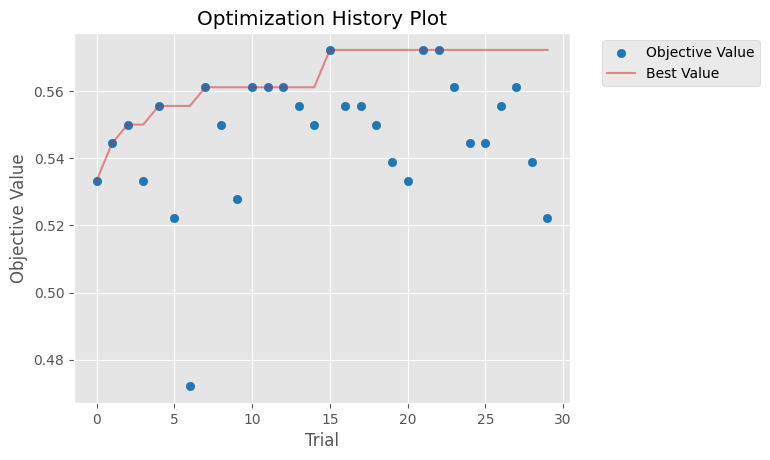

In [52]:
import warnings
import optuna.visualization.matplotlib as vis_matplotlib

# Suppress warning and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study)

# Save the plot
fig = ax.figure
fig.savefig("optuna_optimization_history_unetadaboost.png", dpi=300, bbox_inches='tight')

In [53]:
adaboost_params = study.best_params
print(adaboost_params)

{'n_estimators': 100, 'learning_rate': 0.05, 'Fe': 5}


In [54]:
final_params_adaboost = dict(n_estimators = adaboost_params['n_estimators'], learning_rate = adaboost_params['learning_rate'], Fe = adaboost_params['Fe'])

In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

# Already extracted features for trainval
X_trainval_flat = features.reshape(features.shape[0], -1)

# Extract and flatten test features
features_test = feature_extractor.predict(X_test)
X_test_flat = features_test.reshape(features_test.shape[0], -1)

# PCA using Fe from best Optuna parameters
pca = PCA(n_components=final_params_adaboost['Fe'])
X_trainval_reduced = pca.fit_transform(X_trainval_flat)
X_test_reduced = pca.transform(X_test_flat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step


In [56]:
# Retrain AdaBoost with the final best hyperparameters on the combined trainval set
clf_adaboost = AdaBoostClassifier(n_estimators=final_params_adaboost['n_estimators'], learning_rate=final_params_adaboost['learning_rate'], random_state=42)
clf_adaboost.fit(X_trainval_reduced, y_trainval)

AdaBoostClassifier(learning_rate=0.05, n_estimators=100, random_state=42)

In [57]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, log_loss, brier_score_loss, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc)

# Define the evaluate_model function to compute the metrics, create the confusion matrix, and the ROC curve

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute the metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)  # add zero_division=0 to handle undefined metrics
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    print("\n Binary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


FINAL ADABOOST MODEL EVALUATION ON TEST SET

 Binary Classification Evaluation
Accuracy:             0.5870
Balanced Accuracy:    0.5365
Precision:            0.6000
Recall (Sensitivity): 0.1500
F1 Score:             0.2400
Log Loss:             0.7268
Brier Score:          0.2630
AUC-ROC:              0.5298

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.59      0.92      0.72        26
    Demented       0.60      0.15      0.24        20

    accuracy                           0.59        46
   macro avg       0.59      0.54      0.48        46
weighted avg       0.59      0.59      0.51        46



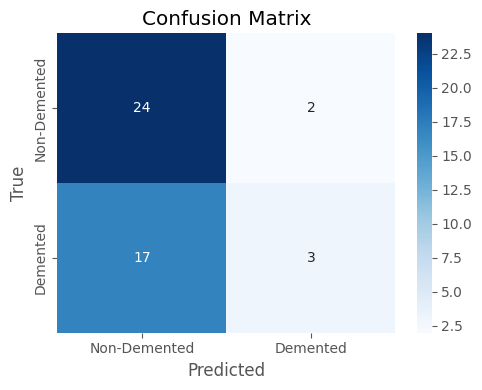

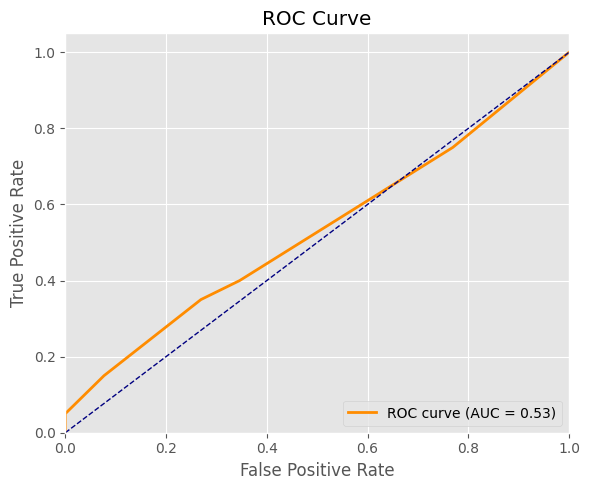

In [58]:
# Predict on test set
y_test_pred = clf_adaboost.predict(X_test_reduced)
y_test_proba = clf_adaboost.predict_proba(X_test_reduced)[:, 1]  # Probability for class 'Demented'

# Evaluate the model
print("FINAL ADABOOST MODEL EVALUATION ON TEST SET")

test_metrics = evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Plot the confusion matrix and save it
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Demented', 'Demented'],
            yticklabels=['Non-Demented', 'Demented'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (AdaBoost)")
plt.tight_layout()
plt.savefig("confusion_matrix_default_threshold.png", dpi=300)
plt.close()

EVALUATION WITH OPTIMAL THRESHOLD: 0.2399

 Binary Classification Evaluation
Accuracy:             0.4348
Balanced Accuracy:    0.5000
Precision:            0.4348
Recall (Sensitivity): 1.0000
F1 Score:             0.6061
Log Loss:             0.7268
Brier Score:          0.2630
AUC-ROC:              0.5298

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.00      0.00      0.00        26
    Demented       0.43      1.00      0.61        20

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46



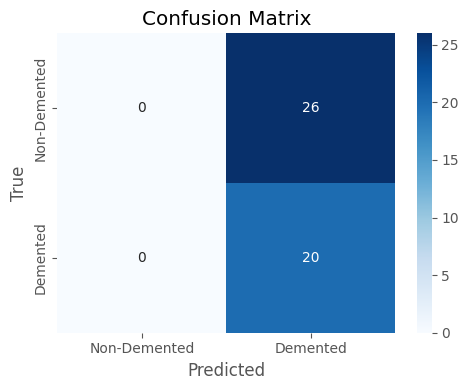

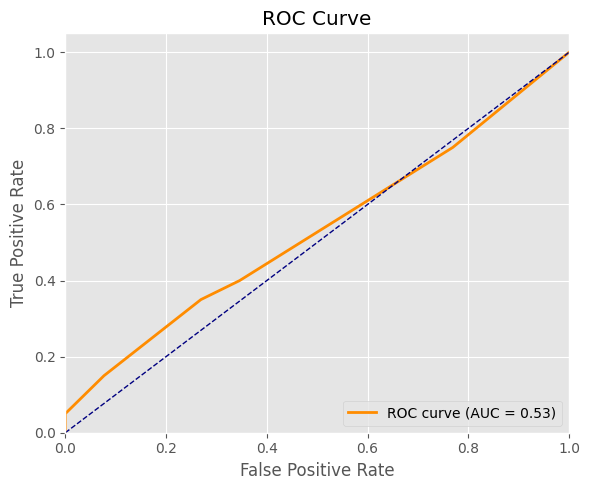

In [59]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute precision, recall, and thresholds
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"EVALUATION WITH OPTIMAL THRESHOLD: {optimal_threshold:.4f}")

# Apply optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate the model using adjusted predictions
evaluate_model(y_true=y_test, y_pred=y_test_pred_optimal, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Plot the confusion matrix for optimal threshold and save it
cm = confusion_matrix(y_test, y_test_pred_optimal)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Demented', 'Demented'], yticklabels=['Non-Demented', 'Demented'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
plt.tight_layout()
plt.savefig("confusion_matrix_optimal_threshold.png", dpi=300)
plt.close()

In [60]:
tracker.stop()

[codecarbon INFO @ 13:55:15] Energy consumed for RAM : 0.002582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:55:15] Delta energy consumed for CPU with constant : 0.000115 kWh, power : 42.5 W
[codecarbon INFO @ 13:55:15] Energy consumed for All CPU : 0.010978 kWh
[codecarbon INFO @ 13:55:15] 0.013560 kWh of electricity used since the beginning.


0.0036289745855391836

In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Convert the emissions CSV to Excel and save it in the folder
csv_path = os.path.join(output_folder, "Unet+AdaBoost_emissions.csv")
excel_path = os.path.join(output_folder, "Unet+AdaBoost_emissions.xlsx")

df = pd.read_csv(csv_path)
df.to_excel(excel_path, index=False)